# Figure 3
## Warnings:
- This program takes around 4 hours to run using the default settings, with a fast computer.
- By default, this program uses 10 concurrent processes. This results in a significant amount of memory being used at once during the most intensive periods (needed to store the $(\langle k \rangle$, $\mathrm{CSM})$ pairs for Figure 4). If the computer does not have enough space, the program may cause the computer to freeze/malfunction. To avoid this, reduce the number of concurrent processes (<code>nj</code>). You can also just comment out the code which stores/saves that extra data (<code>pair_data</code> in this file)
- The safest setting is when there is only 1 or 2 concurrent proceses, however, this can cause the program to take much longer to complete.
- You can reproduce a similar version of the figure, that takes much less time/space to compute, if you reduce the number of repetitions (<code>n_repeats</code>) and/or the number of surrogates (<code>n_surrogates</code>). For example, only 5 repetitions and 5 surrogates should take less than 10 minutes on a fast computer. However, this may cause the results to appear slightly different than what is in the paper. Other choices to reduce the compuation time include computing only one frequency interval (<code>f_names</code>, <code>bands</code>), or less values of $\rho$.

## Information:
- In addition to Figure 3, the statistics in the results section 4.1 are generated in this file (see Figure3 folder --> <code>pval_df.csv</code>)
- The list <code>pair_data</code> is used to store the pairs which generate Figure 4.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from ts2vg import HorizontalVG
import matplotlib as mpl
from sklearn.metrics import normalized_mutual_info_score
from scipy.stats import pearsonr
from scipy.signal import csd
import colorednoise as cn
from time import ctime
from joblib import Parallel, delayed
from scipy.stats import combine_pvalues
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
from functools import reduce
from functions import *

nj = 10
np.set_printoptions(suppress=True)
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'arial'

In [2]:
def shuffle(x, n_segments):
    groups = np.reshape(x, (n_segments, int(len(x)/n_segments)))
    np.random.shuffle(groups)
    x_new = np.reshape(groups, len(x))
    return x_new

csm_list = ['closeness', 'betweenness', 'eigenvector']
def compute_fc(fs, x, y, win):
    # Using Welch's method to estimate the power spectral density
    # The choice of window is recommended to "encompass 2 cycles of lowest
    # frequency of interest" - for us it is 4 Hz, so 2/4 = 0.5 seconds
    nperseg = 0.5 * fs

    f, sxy = csd(x, y, fs=fs, nperseg=nperseg)
    f, sxx = csd(x, x, fs=fs, nperseg=nperseg)
    f, syy = csd(y, y, fs=fs, nperseg=nperseg)

    msc = (np.abs(np.mean(sxy))**2) / (np.mean(sxx) * np.mean(syy))
    wpli = np.abs(np.mean(np.imag(sxy))) / np.mean(np.abs(np.imag(sxy)))
    ic = np.abs(np.imag(np.mean(sxy)) / np.sqrt(np.mean(sxx) * np.mean(syy)))
    
    vg_list = gen_vg(np.array([x, y]), 'HVG')
    nmi = get_final_corr(vg_list)

    w = fs//2
    w_s = w//2
    scores, pair_data = [], []
    for centrality in csm_list:
        # x and y are the same, just shifted by tau and added independent random
        # noise. Thus, we only need to show the pair_data for x (or y, but we use x)
        css_score, x_pair_data, _ = css(x, y, w, w_s, centrality)
        scores.append(css_score)
        pair_data.append(x_pair_data) 
    
    pcc = abs(pearsonr(x, y).statistic)
    _, _, avg_le = edge_overlap(*vg_list)
    
    labels = ['CSS (CSM: ACC)', 'CSS (CSM: ABW)', 'CSS (CSM: AEV)', 
              'NMI', 'ALE', 'PCC', 'MSC', 'IC', 'WPLI']
    scores.extend([nmi, avg_le, pcc, ic, msc, wpli])
    return (labels, scores, pair_data)

## Simulation Experiment

In [3]:
bands = [[4,7], [8, 30], [30, 40], [30, 50]]
f_names = ['$f_1$', '$f_2$', '$f_3$', '$f_4$']
params = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99] 
n_repeats, n_surrogates = 50, 50

all_data = []
main = 'Figure3'
make_directory(f'{main}')
make_directory(f'{main}/corr')
np.savetxt(f'{main}/params.csv', params, delimiter=',')

for win, f_name in zip(bands, f_names):
    def g(rho):
        theta, fs, length, delay, rstate = 0.5, 150, 6000, 5, None
        n_methods, n_csm = 9, len(csm_list)
        spi_scores, pair_data = [], [[[], []] for _ in range(n_csm)]
        print('starting', rho, ctime())
        
        for i in range(n_repeats):
            print('repeat', i, ctime())
            x, y = get_data(fs, win, length, delay, 0, None)
            n1 = get_noise(theta, length, fs, win)
            n2 = get_noise(theta, length, fs, win)        
            N_x = normalize_signal(rho*x + (1-rho)*n1, fs, win)
            N_y = normalize_signal(rho*y + (1-rho)*n2, fs, win)
            
            labels, spis, pairs = compute_fc(fs, N_x, N_y, win)
            spi_scores.extend(list(map(lambda i: [f_name, rho, labels[i], spis[i], False], range(len(labels)))))
    
            # We save the results of the average weighted degree - CSM Value pairs, and it is OKAY to do this 
            # within the parallel thread itself (instead of after all threads are complete)  because it only
            # ever happens in one parallel thread
            if rho in [0.8]: 
                for ct in range(len(pair_data)):
                    pairs_T = np.transpose(pairs[ct])
                    pair_data[ct][0].extend(pairs_T[0])
                    pair_data[ct][1].extend(pairs_T[1])

            for ind in range(n_surrogates):
                y_shuffle = shuffle(y.copy(), int(length/(int(fs)))) 
                N_y_shuffle = normalize_signal(rho*y_shuffle + (1-rho)*n2, fs, win)
                _, surr_spis, _ = compute_fc(fs, N_x, N_y_shuffle, win)
                surr_result = list(map(lambda i: [f_name, rho, labels[i], surr_spis[i], True], range(len(labels))))
                spi_scores.extend(surr_result)

        print("corr shape", np.array(pair_data).shape)
        return (spi_scores, pair_data)  

    print('parallels started', ctime(), flush=True)
    output = Parallel(n_jobs=nj, verbose=1)(delayed(g)(rho) for rho in params)
    #output = [g(rho) for rho in params]
    print('parallels done', ctime(), flush=True) # list of tuples

    data = []
    for params_ct in range(len(params)):
        rho = params[params_ct]
        spi_scores, pair_data = output[params_ct]
        data.extend(spi_scores)

        for ct in range(len(pair_data)):
            np.savetxt(f'{main}/corr/{csm_list[ct]}_{rho}_{f_name}.csv', pair_data[ct], delimiter=',')
    
    all_data.extend(data)

    df = pd.DataFrame(data, columns =['frequency range', 'rho', 'method', 'score', 'is-surrogate'])
    df.to_csv(f'{main}/{f_name}.csv', index=False)

df = pd.DataFrame(all_data, columns =['frequency range', 'rho', 'method', 'score', 'is-surrogate'])
df.to_csv(f'{main}/df.csv', index=False)

parallels started Fri Mar 28 09:27:51 2025


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed: 54.5min remaining: 217.9min


parallels done Fri Mar 28 10:23:31 2025


[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed: 55.7min finished


parallels started Fri Mar 28 10:23:34 2025


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed: 58.0min remaining: 232.1min


parallels done Fri Mar 28 11:26:04 2025


[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed: 62.5min finished


parallels started Fri Mar 28 11:26:06 2025


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed: 57.8min remaining: 231.1min


parallels done Fri Mar 28 12:25:28 2025


[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed: 59.4min finished


parallels started Fri Mar 28 12:25:31 2025


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed: 57.5min remaining: 230.0min


parallels done Fri Mar 28 13:24:18 2025


[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed: 58.8min finished


starting CSS (CSM: ACC)


C:\Users\ateymo2\Python\Lib\site-packages\scipy\stats\_stats_py.py:9329: RuntimeWarning: divide by zero encountered in log1p
  statistic = 2 * np.sum(np.log1p(-pvalues))


starting CSS (CSM: ABW)
starting CSS (CSM: AEV)
starting NMI
starting ALE
starting PCC
starting MSC
starting IC
starting WPLI
starting CSS (CSM: ACC)
starting CSS (CSM: ABW)
starting CSS (CSM: AEV)
starting NMI
starting ALE
starting PCC
starting MSC
starting IC
starting WPLI


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


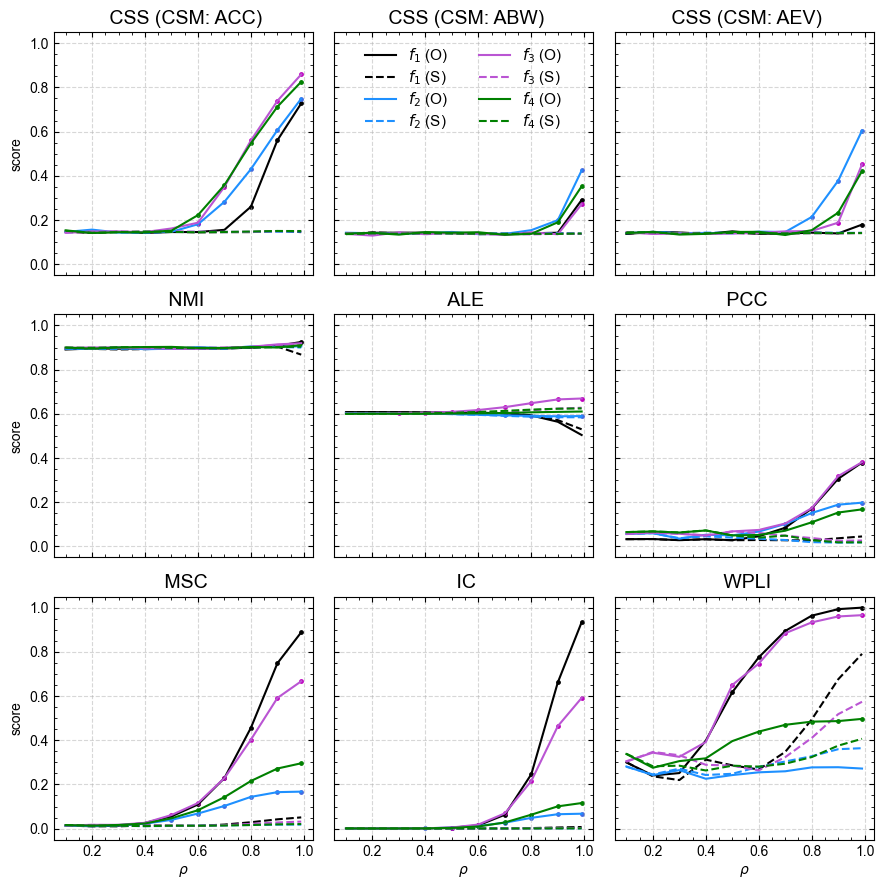

In [6]:
palette = ['black', 'black', 'dodgerblue', 'dodgerblue', 'mediumorchid', 'mediumorchid', 'green', 'green']
linestyle = ['-', '--', '-', '--', '-', '--', '-', '--']
kw = {'color': palette, 'linestyle': linestyle} 
labels = ['CSS (CSM: ACC)', 'CSS (CSM: ABW)', 'CSS (CSM: AEV)', 
          'NMI', 'ALE', 'PCC', 'MSC', 'IC', 'WPLI']

hue = 'frequency range'
df = pd.read_csv(f'{main}/df.csv', sep=',')
df[hue] = df['frequency range'] + ' (' + df['is-surrogate'].apply(lambda x: "S)" if x else "O)")

g = sns.FacetGrid(df, col="method", col_wrap=3, hue=hue, palette=palette, 
                  hue_kws=kw, col_order = labels)

g.map_dataframe(sns.lineplot, x="rho", y="score", err_style='band', errorbar=None)

g.axes[1].legend(frameon=False, labelspacing=0.2, ncol=2,
                 loc='upper center', fontsize=11)

params = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99] 
colors= ['black', 'royalblue',  'm',  'g']

data, pval_hat_vals = [], []
df = pd.read_csv(f'{main}/df.csv', sep=',')
for i in range(len(labels)):
    method = labels[i]
    print('starting', method)
    
    for j in range(len(colors)):
        band, color = f_names[j], colors[j]

        for rho_ind in range(len(params)):
            rho = params[rho_ind]
            S1 = df.loc[(df['method'] == method) & (df['frequency range'] == band) & (df['rho'] == rho)]
            true_lst = S1.loc[S1['is-surrogate'] == False]['score'].to_numpy()
            surrogate_lst = S1.loc[S1['is-surrogate'] == True]['score'].to_numpy()
            
            pvals = []
            weights = []
            for k in range(n_repeats):
                start, stop = k + n_surrogates*k, k + n_surrogates + n_surrogates*k
                true_v, surr_vals = true_lst[k], surrogate_lst[start:stop]
                pval = reduce(lambda a, surr_v: a + 1 if surr_v > true_v else a, surr_vals, 0) / (n_surrogates)
                pvals.append(pval)
                weights.append(np.mean(list(map(lambda surr_v: abs(true_v - surr_v), surr_vals))))

            pval_hat = combine_pvalues(pvals, method='pearson').pvalue
            pval_hat_vals.append(pval_hat)
            data.append([method, band, rho, np.mean(weights), pval_hat])

pval_df = pd.DataFrame(data, columns = ['method', 'band', 'rho','avg-dist','pval_hat'])
pval_hat_vals = fdrcorrection(pval_hat_vals)[1]
pval_df.insert(len(pval_df.columns), "corrected pval_hat", pval_hat_vals)
pval_df.to_csv(f'{main}/pval_df.csv', sep=',')

c = 0
for i in range(len(labels)):
    method = labels[i]
    print('starting', method)
    
    for j in range(len(colors)):
        band, color = f_names[j], colors[j]

        for rho_ind in range(len(params)):
            rho = params[rho_ind]
            S1 = df.loc[(df['method'] == method) & (df['frequency range'] == band) & (df['rho'] == rho)]
            true_lst = S1.loc[S1['is-surrogate'] == False]['score'].to_numpy()
            surrogate_lst = S1.loc[S1['is-surrogate'] == True]['score'].to_numpy()
            pval_hat = pval_hat_vals[c]
            
            if pval_hat < 0.001: # alpha = 0.001
                g.axes[i].scatter([rho], [np.mean(true_lst)], c=color, s=6, marker='o')
            
            c += 1

titlesize = 14
for ax in g.axes:
    ax.spines['right'].set_visible(True)
    ax.spines['top'].set_visible(True)
    ax.axis("on")
    ax.minorticks_on()
    ax.set_title(ax.get_title()[8:], fontsize=titlesize)
    ax.tick_params(direction='in', which='both', right=True, top=True)
    ax.grid(alpha=0.5, ls='--')

g.set_xlabels(r'$\rho$')
g.set_ylabels(r'score')

#g.fig.tight_layout()
g.savefig(f'{main}/Figure3.svg', dpi=500, bbox_inches='tight')
g.savefig(f'{main}/Figure3.jpeg', dpi=500, bbox_inches='tight')
g.savefig(f'{main}/Figure3.pdf',  bbox_inches='tight')
g.savefig(f'{main}/Figure3.eps',  bbox_inches='tight')
plt.show()